# Hidden Semi-Markov Model integration test

Let's generate some fake data and see if we can recover it.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import hsmm_forward_backward as fb

%matplotlib inline
sns.set_style('darkgrid')
np.random.seed(12345)

In [2]:
def matshow(X, **kwargs):
    with sns.axes_style("white"):
        ax = plt.matshow(X, aspect='auto', **kwargs);
    return ax

## Set up problem dimensions

In [3]:
T = 5000  # number of times
D = 50  # number of durations
M = 4  # number of hidden state levels

## Make transition matrix and initial state probabilities:

In [4]:
lo, hi = 1, 20
rows = []
for _ in xrange(M):
    alpha = stats.randint.rvs(lo, hi, size=M)
    row = stats.dirichlet.rvs(alpha)
    rows.append(row)
A = np.vstack(rows).T

alpha = stats.randint.rvs(lo, hi, size=M)
pi = stats.dirichlet.rvs(alpha).squeeze()

print A, pi

[[ 0.26734385  0.18894171  0.3160821   0.12843344]
 [ 0.40989557  0.35374087  0.45160354  0.24760838]
 [ 0.04621335  0.39019178  0.15738473  0.38469989]
 [ 0.27654723  0.06712564  0.07492963  0.23925829]] [ 0.6668607   0.05845243  0.25001285  0.02467403]


## Make state chain

In [5]:
# make the chain by evolving each category through time
chain = np.empty((M, T), dtype='int')

# pick pars for duration distribution
mm = 10 * np.random.rand(M) # mean
ss = 3 * np.random.rand(M) # standard deviation

# initialize
t = 0
while t < T:
    if t == 0:
        pp = pi
    else:
        pp = A.dot(chain[:, t - 1])

    # pick a new state
    newstate = np.random.multinomial(1, pp)[:, np.newaxis]
    k = np.argmax(newstate)

    # pick a duration
    d = np.rint(stats.norm.rvs(loc=mm[k], scale=ss[k])).astype('int')
    d = np.min([d, T - d])

    # fill in the next d steps of the chain
    chain[:, t:(t+d)] = newstate
    t += d

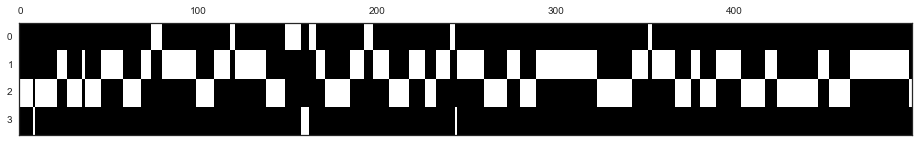

In [6]:
slc = slice(0, 500)
matshow(chain[:, slc], cmap='gray');

## Generate observations

In [7]:
mu = 20 * np.random.rand(M)
sig = 0.5 * np.random.rand(M)

y = stats.norm.rvs(loc=mu.dot(chain), scale=sig.dot(chain), size=T)

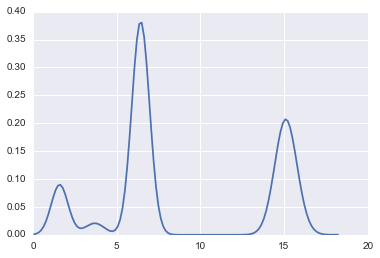

In [8]:
sns.kdeplot(y, bw=0.5);

## Calculate log emission probabilities

In [9]:
logpsi = stats.norm.logpdf(y[:, np.newaxis], loc=mu[np.newaxis, :], scale=sig[np.newaxis, :])

## Calculate distribution of durations

In [10]:
dvec = np.arange(1, D + 1)
logpdf = stats.norm.logpdf(dvec[np.newaxis, :], loc=mm[:, np.newaxis], scale=ss[:, np.newaxis])

# normalize
logpdf -= np.logaddexp.reduce(logpdf, axis=1, keepdims=True)

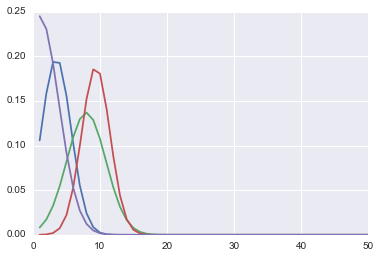

In [11]:
plt.plot(dvec, np.exp(logpdf).T);

## Run algorithm

In [12]:
xi, logZ, Xi, C = fb.fb_infer(np.log(A), np.log(pi), logpsi, dvec, logpdf)

## Plot results

### Hidden States: actual

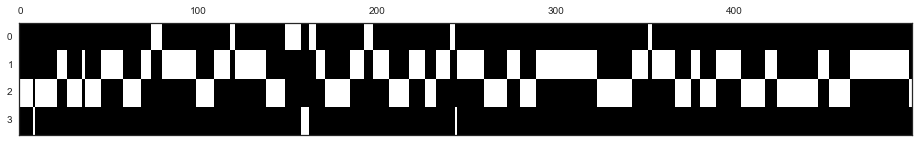

In [13]:
matshow(chain[:, slc], cmap='gray');

### Hidden States: inferred

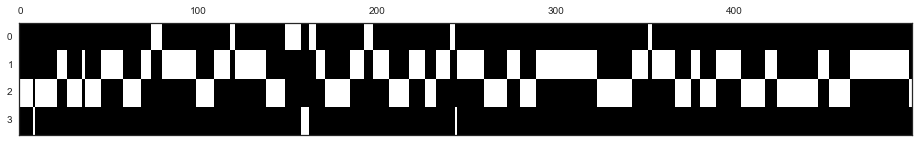

In [14]:
matshow(xi.T[:, slc], cmap='gray');

### Duration distributions: actual

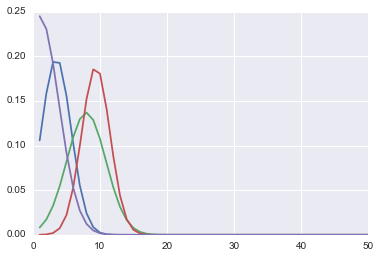

In [15]:
plt.plot(dvec, np.exp(logpdf).T);

### Duration distributions: inferred (maximum likelihood)

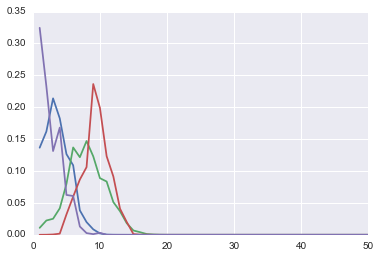

In [16]:
Cred = np.sum(C, 0)
phat = Cred / np.sum(Cred, 1, keepdims=True)
plt.plot(dvec, phat.T);